In [ ]:
pip install yapss



Maximum area = 0.07957747154594769 (Should be 1 / (4 pi) = 0.07957747154594767)
Relative error in solution = 1.743934249004316e-16


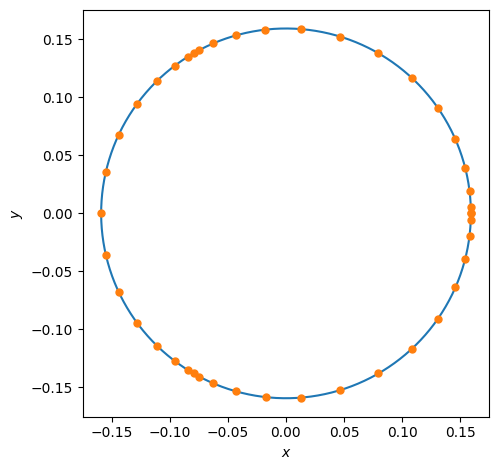

In [ ]:
# Step 1: Import and run the isoperimetric example
from yapss.examples import isoperimetric

# Step 2: Solve the problem
solution = isoperimetric.main()


In [ ]:
# third party imports
import numpy as np
from matplotlib import pyplot as plt

# package imports
from yapss import Problem
from yapss.math import cos, pi, sin, sqrt

problem = Problem(
    name="Lunar Powered Ascent",
    nx=[7],
    nu=[3],
    nh=[2],
    nd=5,
)

In [ ]:
# Lunar Constants

mu = 4.9048695e12   # lunar gravity parameter [m^3/s^2]
R_moon = 1.737e6    # lunar radius [m]
g0 = 1.62           # lunar surface gravity [m/s^2]  (if used for thrust calculations)
rho0 = 0.0          # no atmosphere
omega_e = 0.0       # neglect rotation (or set to a very small value)
h0 = 1.0            # not used, since rho0 is zero

# Vehicle Parameters

pi_vehicle = 15200.0   # Total initial mass (kg)
rho_vehicle = 10920.0   # Propellant mass (kg)
dry_mass = pi_vehicle - rho_vehicle  # Dry mass (kg)
thrust = 30000.0      # Constant engine thrust (N)
burn_time = 435.0      # Burn time (s)
Isp = (thrust*burn_time)/(rho_vehicle*g0)          # Specific impulse (s)
m_total = pi_vehicle   # Used for scaling


# Lunar Orbit Elements

a_target = R_moon + 20000.0  # Semimajor axis (m)
e_target = 0.0                # Eccentricity (circular orbit)
i_target = 0.0                # Inclination (deg)
Omega_target = 0.0            # Longitude of ascending node (deg)
omega_target = 0.0            # Argument of periapsis (deg)

print(Isp)



737.6882376882377


In [ ]:
def cross(x1, x2):
    """Vector cross product."""
    x3 = [0, 0, 0]
    x3[0] = x1[1] * x2[2] - x1[2] * x2[1]
    x3[1] = x1[2] * x2[0] - x1[0] * x2[2]
    x3[2] = x1[0] * x2[1] - x1[1] * x2[0]
    return x3


def mag(x):
    """Vector magnitude."""
    return (sum(xi**2 for xi in x) + 1e-100) ** 0.5


def dot(x1, x2):
    """Vector _dot product."""
    return sum(x1[i] * x2[i] for i in range(3))

In [ ]:
def rv_to_oe(r_vec, v_vec):
    """
    Compute orbital elements from position and velocity vectors.
    Returns: (a, e, i, Omega, omega)
    """
    r = mag(r_vec)
    v = mag(v_vec)
    h_vec = cross(r_vec, v_vec)
    h = mag(h_vec)
    n_vec = cross([0, 0, 1], h_vec)
    n = mag(n_vec)

    # Eccentricity vector calculation:
    e0 = ((v**2 - mu / r)*r_vec[0] - dot(r_vec, v_vec)*v_vec[0]) / mu
    e1 = ((v**2 - mu / r)*r_vec[1] - dot(r_vec, v_vec)*v_vec[1]) / mu
    e2 = ((v**2 - mu / r)*r_vec[2] - dot(r_vec, v_vec)*v_vec[2]) / mu
    e_vec = (e0, e1, e2)
    e = mag(e_vec)

    a = 1 / (2/r - v**2/mu)
    i_angle = np.arccos(h_vec[2]/h) * 180 / pi

    # For Omega, we use a simple convention.
    Omega = 360 - np.arccos(n_vec[0]/n) * 180 / pi if n_vec[1] >= 0 else np.arccos(n_vec[0]/n) * 180 / pi
    omega = np.arccos(dot(n_vec, e_vec)/(n*e)) * 180 / pi if e != 0 else 0.0
    return a, e, i_angle, Omega, omega

In [ ]:
def objective(arg):
    # Maximize the final mass (i.e. minimize the negative final mass).
    arg.objective = -arg.phase[0].final_state[6]

def continuous(arg):
    # Get state and control from phase 0.
    state = arg.phase[0].state
    # Position components
    r1, r2, r3 = state[0:3]
    # Velocity components
    v1, v2, v3 = state[3:6]
    # Mass
    m = state[6]
    # Control (thrust direction)
    u1, u2, u3 = arg.phase[0].control

    # Kinematics: derivative of position is velocity.
    r_dot = [v1, v2, v3]

    # Current radius
    r = (r1**2 + r2**2 + r3**2)**0.5

    # Gravitational acceleration (lunar)
    mu_over_r3 = mu / r**3

    # No atmospheric drag on the Moon.
    d1, d2, d3 = 0.0, 0.0, 0.0

    # Use constant thrust and compute mass flow rate.
    current_thrust = thrust
    m_dot = -current_thrust / (g0 * Isp)

    # Dynamics: acceleration = gravitational + thrust contribution.
    a1 = -mu_over_r3 * r1 + (current_thrust / m) * u1
    a2 = -mu_over_r3 * r2 + (current_thrust / m) * u2
    a3 = -mu_over_r3 * r3 + (current_thrust / m) * u3

    # Set the dynamics: [position derivatives, velocity derivatives, mass derivative]
    arg.phase[0].dynamics[:] = r_dot + [a1, a2, a3] + [m_dot]

    # Path constraint: enforce that the vehicle remains above the lunar surface.
    arg.phase[0].path[:] = r

def discrete(arg):
    # Extract final state from phase 0.
    state_final = arg.phase[0].final_state
    r_vec = state_final[:3]
    v_vec = state_final[3:6]
    # Compute orbital elements from the final state.
    oe = rv_to_oe(r_vec, v_vec)  # (a, e, i, Omega, omega)
    # Set discrete constraints: differences between computed and target orbital elements.
    arg.discrete[:] = [oe[0] - a_target,
                       oe[1] - e_target,
                       oe[2] - i_target,
                       oe[3] - Omega_target,
                       oe[4] - omega_target]

problem.functions.objective = objective
problem.functions.continuous = continuous
problem.functions.discrete = discrete

In [ ]:
psi_l = 0.0  # Launch latitude in radians.
x0 = [R_moon * cos(psi_l), 0.0, R_moon * sin(psi_l)]
v0 = [0.0, 0.0, 0.0]  # Assume initial velocity is zero.
state_0 = x0 + v0 + [pi_vehicle]  # [x, y, z, vx, vy, vz, mass]

# Time bounds.
t0 = 0.0
t_final = burn_time

# Set phase 0 bounds.
bounds = problem.bounds.phase[0]
bounds.initial_time.lower = bounds.initial_time.upper = t0
bounds.final_time.lower = bounds.final_time.upper = t_final
bounds.initial_state.lower[:] = bounds.initial_state.upper[:] = state_0

# Set state bounds (position, velocity, mass).
r_max = 10 * R_moon
v_max = 10000.0  # m/s (example)
bounds.state.lower[:3] = 3 * [-r_max]
bounds.state.upper[:3] = 3 * [r_max]
bounds.state.lower[3:6] = 3 * [-v_max]
bounds.state.upper[3:6] = 3 * [v_max]
bounds.state.lower[6] = dry_mass - 10  # Allow a small leeway.
bounds.state.upper[6] = pi_vehicle + 10
bounds.final_state.lower[6] = dry_mass - 10
bounds.final_state.upper[6] = pi_vehicle + 10

# Path constraint: vehicle’s distance from the lunar center must be at least R_moon.
bounds.path.lower[:] = [R_moon]
bounds.path.upper[:] = [1e10]  # High upper bound.

# Discrete constraints: enforce zero difference between computed and target orbital elements.
problem.bounds.discrete.lower[:] = [0, 0, 0, 0, 0]
problem.bounds.discrete.upper[:] = [0, 0, 0, 0, 0]

In [ ]:
problem.guess.phase[0].time = (t0, t_final)
problem.guess.phase[0].state = np.zeros([7, 2])

# For the state guess, set initial state at the lunar surface and a rough final guess.

target_position = [R_moon + 20000.0, 0.0, R_moon]  # Example: 20 km altitude above the surface in x.
problem.guess.phase[0].state[:3, 0] = state_0[:3]
problem.guess.phase[0].state[:3, 1] = target_position
# Linear guess for mass: from initial mass to (pi_vehicle - rho_vehicle).
problem.guess.phase[0].state[6, :] = [pi_vehicle, pi_vehicle - rho_vehicle]
# For velocities, a zero guess.
problem.guess.phase[0].state[3:6, :] = np.zeros((3,2))
# Control guess: thrust directed along the positive x-axis.
problem.guess.phase[0].control = [[1.0, 1.0],
                                  [0.0, 0.0],
                                  [0.0, 0.0]]

In [ ]:
length_scale = R_moon
mass_scale = pi_vehicle
velocity_scale = sqrt(mu / length_scale)
time_scale = length_scale / velocity_scale

problem.scale.phase[0].state[0:3] = length_scale
problem.scale.phase[0].state[3:6] = velocity_scale
problem.scale.phase[0].state[6] = mass_scale
problem.scale.phase[0].dynamics[0:3] = length_scale
problem.scale.phase[0].dynamics[3:6] = velocity_scale
problem.scale.phase[0].dynamics[6] = mass_scale
problem.scale.phase[0].time = time_scale
problem.scale.phase[0].path[:] = 1, length_scale

# Scale discrete constraints: scale semimajor axis by length_scale; others left as is.
problem.scale.discrete[:] = [length_scale, 1, 1, 1, 1]
problem.scale.objective = mass_scale

In [ ]:
problem.spectral_method = "lgl"
problem.derivatives.method = "auto"
problem.derivatives.order = "second"

# Simple mesh for phase 0.
m, n = 5, 5
problem.mesh.phase[0].collocation_points = m * (n,)
problem.mesh.phase[0].fraction = m * (1.0/m,)

# Ipopt options.
problem.ipopt_options.tol = 1e-20
problem.ipopt_options.max_iter = 1000
problem.ipopt_options.sb = "yes"
problem.ipopt_options.print_level = 3
problem.ipopt_options.print_user_options = "no"
problem.ipopt_options.linear_solver = "mumps"

In [ ]:
np.seterr(invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [ ]:
solution = problem.solve()

In [ ]:
print("Objective (final mass maximized):", -solution.objective)

Objective (final mass maximized): 11257.752299917116


In [ ]:
# Final state is the last column in the state array
final_state = solution.phase[0].state[:, -1]
print("Final state:", final_state)

# Final mass (last element)
print("Final mass:", final_state[6])

# Also print the final time
print("Final time:", solution.phase[0].time[-1])


Final state: [ 1.40588598e+06  2.68340079e-58  2.09467104e+06 -1.55474736e+03
  4.31792684e-59 -1.53704961e+03  1.12577523e+04]
Final mass: 11257.752299917116
Final time: 435.0


In [ ]:
x = solution.phase[0].state      # state: shape (7, N) --> [x, y, z, vx, vy, vz, mass]
u = solution.phase[0].control    # control: shape (3, N)

try:
    p = solution.phase[0].costate    # costate: shape (7, N)
except AttributeError:
    p = None
f = solution.phase[0].dynamics   # dynamics: shape (7, N)
t = solution.phase[0].time       # time vector (N,)
try:
    tc = solution.phase[0].time_c
except AttributeError:
    tc = t

tf = t[-1]  # Final time

In [ ]:
v_mag = np.sqrt(x[3]**2 + x[4]**2 + x[5]**2)

# Compute Hamiltonian if costates are available.
if p is not None:
    # Hamiltonian: at each time, sum(p[i] * f[i]) for i in range(7)
    hamiltonian = np.sum(p * f, axis=0)
else:
    hamiltonian = None

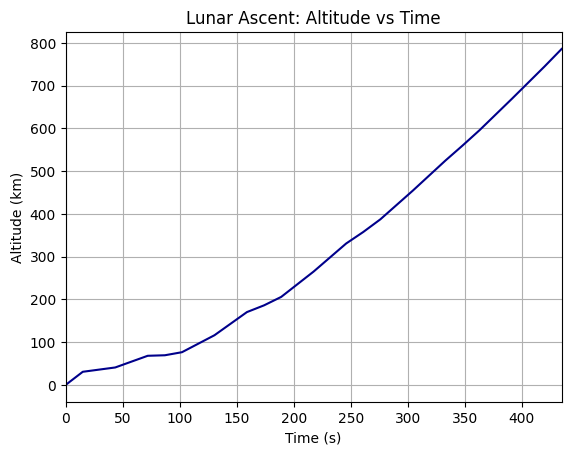

In [ ]:
altitude = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2) - R_moon

plt.figure()
plt.plot(t, altitude / 1000, "darkblue")
plt.xlabel("Time (s)")
plt.ylabel("Altitude (km)")
plt.title("Lunar Ascent: Altitude vs Time")
plt.grid(True)
plt.xlim([0, tf])
plt.show()

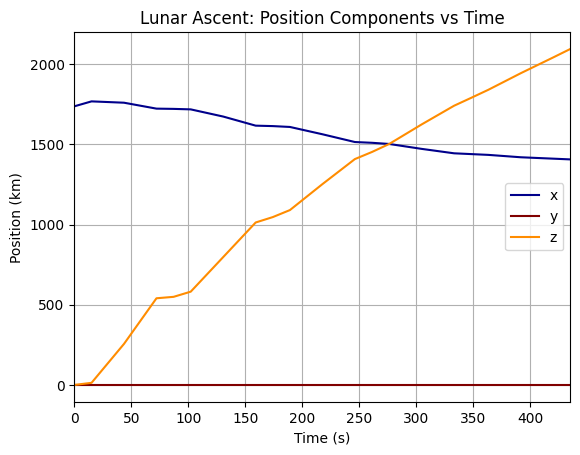

In [ ]:
plt.figure()
plt.plot(t, x[0] / 1000, "darkblue", label="x")
plt.plot(t, x[1] / 1000, "maroon", label="y")
plt.plot(t, x[2] / 1000, "darkorange", label="z")
plt.xlabel("Time (s)")
plt.ylabel("Position (km)")
plt.title("Lunar Ascent: Position Components vs Time")
plt.legend()
plt.grid(True)
plt.xlim([0, tf])
plt.show()

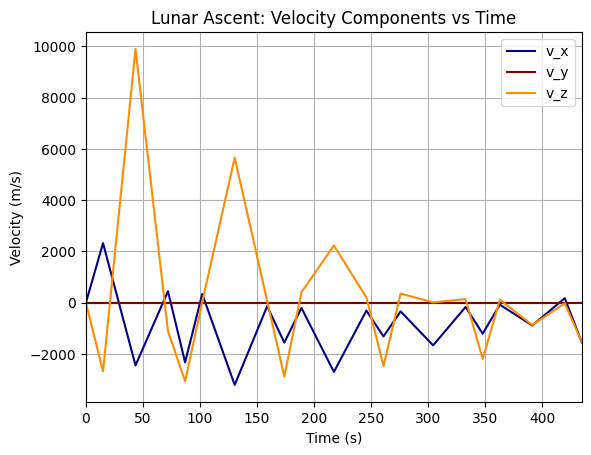

In [ ]:
plt.figure()
plt.plot(t, x[3], "darkblue", label="v_x")
plt.plot(t, x[4], "maroon", label="v_y")
plt.plot(t, x[5], "darkorange", label="v_z")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Lunar Ascent: Velocity Components vs Time")
plt.legend()
plt.grid(True)
plt.xlim([0, tf])
plt.show()

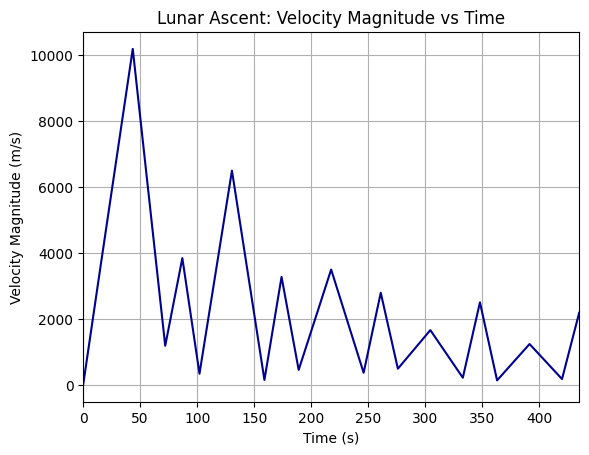

In [ ]:
plt.figure()
plt.plot(t, v_mag, "darkblue")
plt.xlabel("Time (s)")
plt.ylabel("Velocity Magnitude (m/s)")
plt.title("Lunar Ascent: Velocity Magnitude vs Time")
plt.grid(True)
plt.xlim([0, tf])
plt.show()

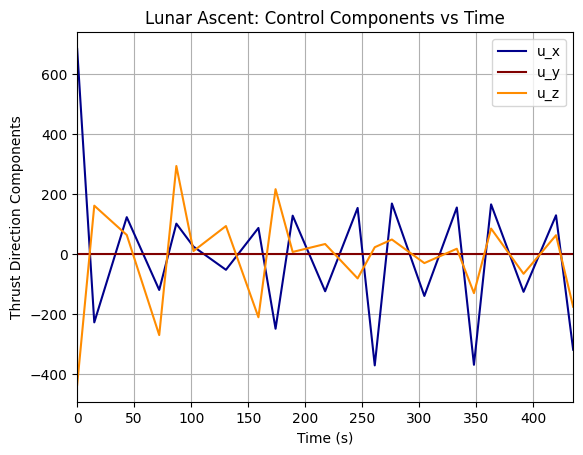

In [ ]:
plt.figure()
plt.plot(t, u[0], "darkblue", label="u_x")
plt.plot(t, u[1], "maroon", label="u_y")
plt.plot(t, u[2], "darkorange", label="u_z")
plt.xlabel("Time (s)")
plt.ylabel("Thrust Direction Components")
plt.title("Lunar Ascent: Control Components vs Time")
plt.legend()
plt.grid(True)
plt.xlim([0, tf])
plt.show()

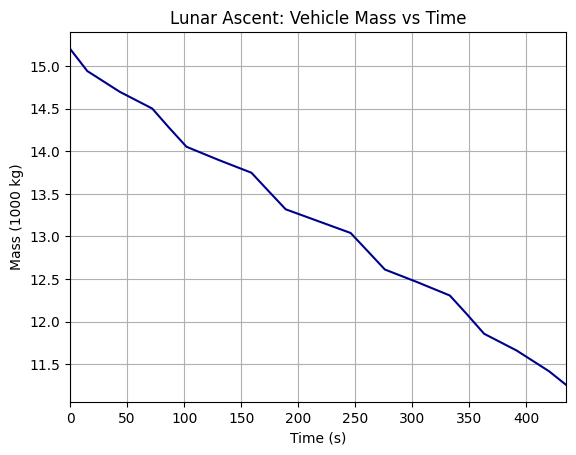

In [ ]:
plt.figure()
plt.plot(t, x[6] / 1000, "darkblue")
plt.xlabel("Time (s)")
plt.ylabel("Mass (1000 kg)")
plt.title("Lunar Ascent: Vehicle Mass vs Time")
plt.grid(True)
plt.xlim([0, tf])
plt.show()

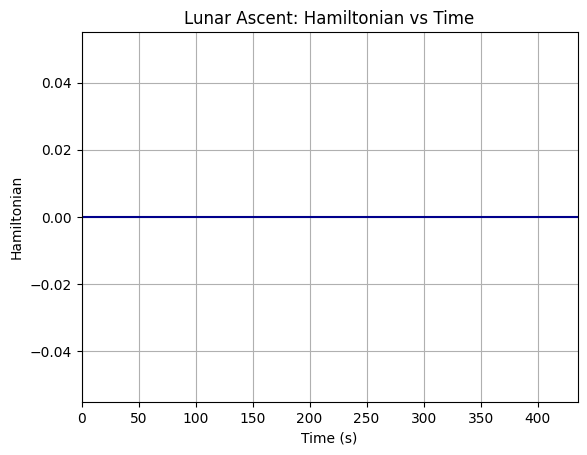

In [ ]:
if hamiltonian is not None:
    plt.figure()
    plt.plot(t, hamiltonian, "darkblue")
    plt.xlabel("Time (s)")
    plt.ylabel("Hamiltonian")
    plt.title("Lunar Ascent: Hamiltonian vs Time")
    plt.grid(True)
    plt.xlim([0, tf])
    plt.show()